# Experimento com KNN em Sistema de Recomendação
Alunos: Eric Bernard e Sérgio Rezende

## Imports

Importação das bibliotecas que serão utilizadas para lidar com o banco de dados e com a matemática.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import math

## Importando e tratando o Dataset
Utilizando o pandas para pegar o dataset do Movielens com 100 mil notas.

In [2]:
ratingsDf = pd.read_csv('../../data/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

Pegando a matriz de notas com a função "pivot_table" do pandas e depois transformando em array.

In [3]:
ratingsDfPivotTable = ratingsDf.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=None)
ratingMatrix = np.array(ratingsDfPivotTable.values)
print(f"Dimensões da matriz de notas: {ratingMatrix.shape}")
ratingsDfPivotTable

Dimensões da matriz de notas: (943, 1682)


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para testar o KNN pegamos um sample de 5000 notas e depois removemos essas notas da matriz de notas.

In [4]:
# Pegando avaliações para usar de teste
x_test = ratingsDf.sample(n=5000, random_state=123)

# Transformando em NaN na matriz de notas os valores de teste
for _ , row in x_test.iterrows():
    ratingMatrix[row['user_id'] - 1][row['item_id'] - 1] = np.nan

## Definição dos Cálculos de Similaridade

In [5]:
def cos_similarity(x1, x2):
    sum1 = np.nansum(x1 * x2)
    sum2 = np.nansum(x1 ** 2)
    sum3 = np.nansum(x2 ** 2)
    return 1 - (sum1 / (np.sqrt(sum2) * np.sqrt(sum3)))

def euclidean_similarity(x1, x2):
    sum = np.nansum((x1 - x2) ** 2)
    return np.sqrt(sum)

## Classe do KNN

In [6]:
class KNN:
    def __init__(self, k, similarity, ratingMatrix, min_coavaliados=5):
        self.k        = k
        self.similarity = similarity
        self.ratingMatrix = ratingMatrix
        self.min_coavaliados = min_coavaliados

    def predict(self, userId, itemsId):
        similarities = []
        for otherUserId in range(self.ratingMatrix.shape[0]):
            if otherUserId != userId:
                similarity = self.similarity(self.ratingMatrix[userId], self.ratingMatrix[otherUserId])
                n_coavaliados = np.count_nonzero(~np.isnan(self.ratingMatrix[userId]) & ~np.isnan(self.ratingMatrix[otherUserId]))
                if n_coavaliados >= self.min_coavaliados:
                    similarities.append((otherUserId, similarity))
        
        sortedSimilarities = sorted(similarities, key=lambda x: x[1])
        kNearestNeighbors = sortedSimilarities[:self.k]
        predictedValues = []
        for itemId in itemsId:
            predictedValues.append(np.nanmean([self.ratingMatrix[neighbor[0], itemId] for neighbor in kNearestNeighbors]))
        return predictedValues

## Treino e teste do modelo

Função criada para pegar o erro do modelo.

In [7]:
def get_errors(knn, y, usersInTest, itemsId):
    predictedValues = []
    for userId in usersInTest:
        predictedValues = np.append(predictedValues, knn.predict(userId - 1, itemsId[userId - 1]))
    
    nanIndexes = np.argwhere(np.isnan(predictedValues))
    predictedValues = np.delete(predictedValues, nanIndexes)
    y_temp = np.delete(y, nanIndexes)
    rmse = math.sqrt(np.mean((predictedValues - y_temp) ** 2))
    mae = np.mean(np.abs(predictedValues - y_temp))
        
    return rmse, mae

Iterando o k de 10 até 50, pulando 10 em 10. Pegando o rmse e mae de cada iteração.

In [8]:
x_test.sort_values(by=['user_id', 'item_id'], inplace=True)
usersInTest = x_test['user_id'].unique()
itemsId = {}
for userId in usersInTest:
    itemsId[userId - 1] = np.add(np.array(x_test[x_test['user_id'] == userId]['item_id']), -1)
    
y = np.array(x_test['rating'])

k_range = range(5, 75, 5)
rmse_euclidean = []
mae_euclidean = []
rmse_cos = []
mae_cos = []

for k in k_range:
    knn_euclidean = KNN(k, euclidean_similarity, ratingMatrix, 10)
    knn_cos = KNN(k, cos_similarity, ratingMatrix, 10)

    rmse_euclidean_, mae_euclidean_ = get_errors(knn_euclidean, y, usersInTest, itemsId)
    rmse_cos_, mae_cos_ = get_errors(knn_cos, y, usersInTest, itemsId)

    rmse_euclidean.append(rmse_euclidean_)
    mae_euclidean.append(mae_euclidean_)
    rmse_cos.append(rmse_cos_)
    mae_cos.append(mae_cos_)


## Resultados



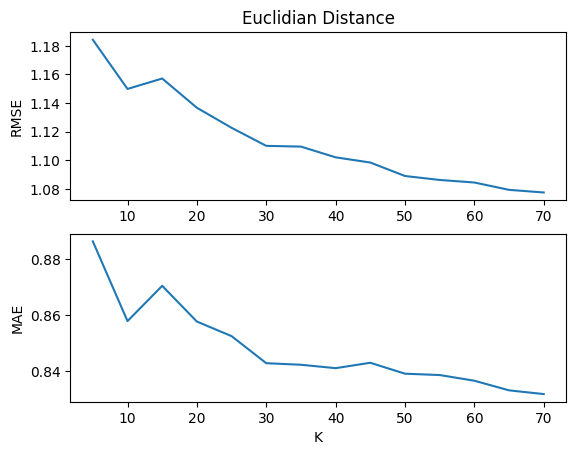

In [9]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmse_euclidean)
ax[0].set_title("Euclidian Distance")
ax[0].set_ylabel("RMSE")
ax[1].plot(k_range, mae_euclidean)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")

plt.show()

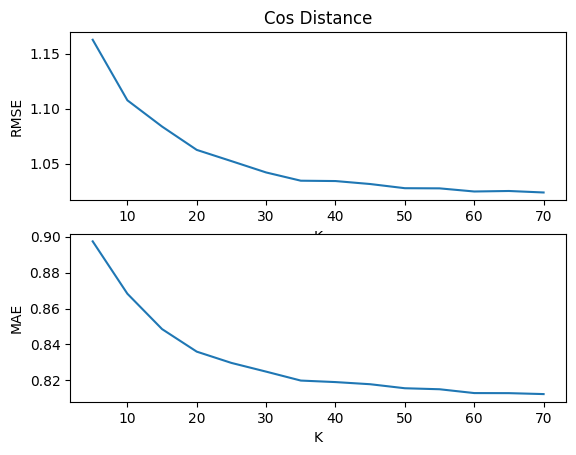

In [10]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmse_cos)
ax[0].set_title("Cos Distance")
ax[0].set_xlabel("K")
ax[0].set_ylabel("RMSE")
ax[1].plot(k_range, mae_cos)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")
plt.show()

Para comparar os resultados obtidos, criamos um modelo que sempre avalia a nota como a média global. É possível ver que o KNN ficou com um desempenho bem melhor.

In [11]:
globalMean = np.nanmean(ratingMatrix)

predicted_global = [globalMean for _ in range(len(y))]


rmse_global = math.sqrt(np.mean((predicted_global - y) ** 2))
rmse_global_arr = [rmse_global for _ in range(len(rmse_euclidean))]

mae_global = np.mean(np.abs(predicted_global - y))
mae_global_arr = [mae_global for _ in range(len(mae_euclidean))]

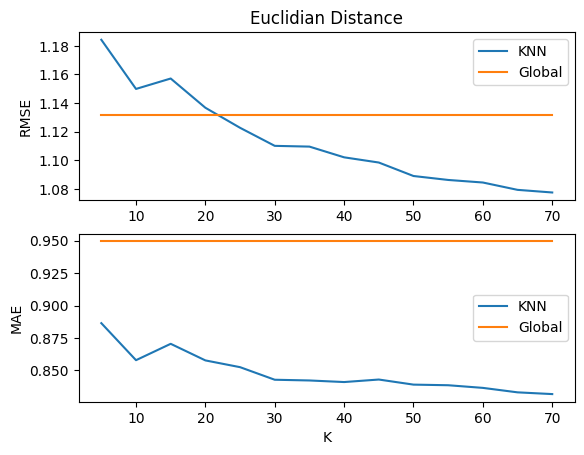

In [12]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmse_euclidean)
ax[0].set_title("Euclidian Distance")
ax[0].set_ylabel("RMSE")
ax[0].plot(k_range, rmse_global_arr)
ax[0].legend(["KNN", "Global"])
ax[1].plot(k_range, mae_euclidean)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")
ax[1].plot(k_range, mae_global_arr)
ax[1].legend(["KNN", "Global"])

plt.show()

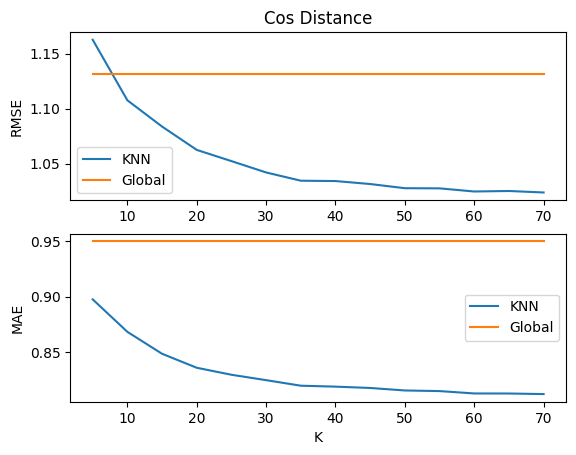

In [13]:
fig, ax = plt.subplots(2)
ax[0].plot(k_range, rmse_cos)
ax[0].set_title("Cos Distance")
ax[0].set_ylabel("RMSE")
ax[0].plot(k_range, rmse_global_arr)
ax[0].legend(["KNN", "Global"])
ax[1].plot(k_range, mae_cos)
ax[1].set_xlabel("K")
ax[1].set_ylabel("MAE")
ax[1].plot(k_range, mae_global_arr)
ax[1].legend(["KNN", "Global"])

plt.show()